# Friends

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
path = Path('data/')
folder= 'Friends'
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
path.ls()

[PosixPath('data/imdb'),
 PosixPath('data/lost+found'),
 PosixPath('data/imdb_sample'),
 PosixPath('data/.ipynb_checkpoints'),
 PosixPath('data/oxford-iiit-pet'),
 PosixPath('data/cars'),
 PosixPath('data/mnist_sample'),
 PosixPath('data/Friends')]

It only contains one csv file, let's have a look at it.

In [4]:
#redefine path
path = Path('data/Friends')
df = pd.read_csv(path/'friends.csv')
df=df.dropna().reset_index()
df.head()

,index,Unnamed: 0,label,text
0,0,0,PHOEBE,Now wasnt Joey hitting on her at the wedding...
1,1,1,CHANDLER,"Oh, oh, a quality, good, because I was worrie..."
2,2,2,ROSS,Then talk to him! He might be fine with it.
3,3,3,MONICA,"Okay. Umm, y'know, I dont think, I dont thi..."
4,4,4,CHANDLER,"Monica, you have got to stop this competitive..."


In [11]:
df['text'][1]

' Oh, oh, a quality, good, because I was worried you guys were gonna be\r\nvague about this.'

## Language model

In [48]:
bs=24

Now let's grab the full dataset for what follows.

In [49]:
data_lm = (TextList.from_df(df,path,cols='text')
           #Inputs: all the text files in path
            #.filter_by_folder(include=['train', 'test']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .random_split_by_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('tmp_lm.pkl')

/opt/conda/envs/fastai/lib/python3.6/site-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [50]:
data_lm = load_data(path, 'tmp_lm.pkl')
data_lm.show_batch()

idx,text
0,"think i told you \r \n this , but umm , i just got out of a really serious relationship . xxbos xxmaj monica , you have got to stop this competitive thing ! xxmaj okay ? xxmaj it 's \r \n crazy . { xxmaj finally ! xxmaj the voice of reason . } i mean , just xxunk xxmaj gary and xxmaj phoebe we have to"
1,"i lost . xxmaj some little girl xxunk her uniform to her xxunk year old \r \n sister , who went down to the xxup xxunk xxmaj xxunk , and sold over 2,000 boxes . xxbos xxmaj all right , who got xxmaj chandler ? cause i uh , need to trade . xxbos xxmaj well , if you think it will help . xxbos i dont think that"
2,"! xxbos xxmaj oh dont forget , my office holiday party is tonight . ( xxmaj they go \r \n into the apartment . ) xxbos xxmaj ok , well , what kind of ritual ? xxbos xxmaj um , you guys , you know when i said before , "" thank you , but i do n't really \r \n need your help "" ? xxbos ("
3,"matter , cause she picked me . xxmaj me ! \r \n xxmaj from now on i get the dates and you have to stay home on xxmaj saturday nights watching xxmaj ready , \r \n xxmaj set , xxmaj cook ! xxbos [ to xxmaj ross ] xxmaj hey , so how 'd it go with xxmaj julie ? xxmaj did you , did you break her"
4,"in , and before you \r \n know it youre right where you dont want to be ! xxmaj back together ! xxbos xxmaj hey xxmaj chandler . xxmaj come on in . xxmaj were xxunk pot xxunk . xxbos i dont suck . xxmaj its sucks . xxmaj you suck . xxbos ( entering and talking on xxunk phone ) xxmaj ok , great ! xxmaj all right"


In [51]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [52]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


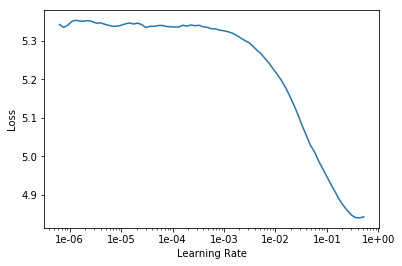

In [53]:
learn.recorder.plot(skip_end=15)

In [54]:
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.923149,3.478520,0.296577,00:17
1,3.431992,3.325138,0.314856,00:17
2,3.260668,3.274450,0.319841,00:17
3,3.129184,3.247529,0.324430,00:17
4,3.045738,3.242267,0.324467,00:17


In [60]:
learn.save('fit_head')

In [61]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [62]:
learn.unfreeze()

In [63]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.421088,3.287974,0.339645,00:23
1,2.448549,3.209658,0.344060,00:23
2,2.303233,3.259724,0.342882,00:23
3,2.074863,3.325111,0.340861,00:23
4,1.940543,3.369549,0.338988,00:23


In [64]:
learn.save('fine_tuned')

In [65]:
learn.load('fine_tuned');

In [66]:
TEXT = "Honey, that's very sweet, it just seems to me though,"
N_WORDS = 10
N_SENTENCES = 2

In [67]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

 
  a great team . i mean
 
  we do n't have any sense of anything


In [69]:
learn.save_encoder('fine_tuned_enc')

## Classifier

In [70]:
#redefine path
path = Path('data/Friends')
df_test = pd.read_csv(path/'friends.csv')
df_test=df_test.dropna().reset_index()
df_test.head()

,index,Unnamed: 0,label,text
0,0,0,ROSS,"Well, I still think I was right about that wh..."
1,1,1,MONICA,"Why?! Why? Why, why would anybody do somethin..."
2,2,2,JOEY,"Ok all right, no, no, no, no, I do, I do, I d..."
3,3,3,PHOEBE,"Yeah, so... They gotta die someday. (Mike's p..."
4,4,4,RACHEL,"Terry, I, I, I know that I haven't worked her..."


In [71]:
data_clas = (TextList.from_df(df,path,cols='text', vocab=data_lm.vocab)
             #grab all the text files in path
             .random_split_by_pct(0.2)
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_df(cols='label')
             #label them all with their folders
            
              #remove data with labels not in above list 
             .databunch(bs=bs))

data_clas.save('data_clas')

/opt/conda/envs/fastai/lib/python3.6/site-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [93]:
data_clas = load_data(path, 'data_clas', bs=bs)

In [94]:
data_clas.classes

['CHANDLER', 'JOEY', 'MONICA', 'PHOEBE', 'RACHEL', 'ROSS']

In [95]:
data_clas.show_batch()

text,target
"xxbos xxmaj me taking care of you is no problem , huh ? xxmaj you guys feel safe . xxmaj right ? \r \n xxmaj okay , xxmaj im gon na take that spit bubble as , "" xxmaj yeah , i do ! "" xxmaj okay , after i get \r \n rid of this dirty diaper xxmaj leslie , xxmaj ill set you up with a",PHOEBE
"xxbos xxmaj no , no its going to be great . xxmaj really ! xxmaj mom , xxmaj dad , when i got \r \n married , one of the things that made me sure i could do it was the amazing example the two \r \n of you set for me . xxmaj for that and so many other things i want to say thank you .",MONICA
"xxbos xxmaj you know what , xxmaj im gon na do that , xxmaj im gon na call him up , and \r \n xxmaj im gon na ask him out . i can do that . xxmaj ask him out . ( xxmaj practising ) xxmaj how you doin ? \r \n ( xxmaj calls him ) xxmaj hi ! xxmaj joshua ? xxmaj its xxmaj rachel",RACHEL
"xxbos xxmaj hi . xxmaj listen , xxmaj im sorry about that whole thing with xxmaj roger . xxmaj it really \r\r\r \n wasnt right , and i , and i want to make it up to you , so umm , i brought you something \r\r\r \n that i think youll really enjoy . ( xxmaj goes into the hallway and returns carrying the \r\r\r \n",PHOEBE
"xxbos ( in his head ) xxmaj say something clever ! ( xxmaj pause . ) xxmaj okay , doesnt \r \n have to be clever , it just has to be words . xxmaj say some words . ( xxmaj pause ) xxmaj any words will \r \n do . ( xxmaj pause ) xxmaj oh my xxmaj god ! xxmaj this is the longest that anyone",ROSS


We can then create a model to classify those reviews and load the encoder we saved before.

In [96]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (23783 items)
x: TextList
xxbos xxmaj now wasnt xxmaj joey hitting on her at the wedding too ?,xxbos xxmaj then talk to him ! xxmaj he might be fine with it .,xxbos xxmaj monica , you have got to stop this competitive thing ! xxmaj okay ? xxmaj it 's 
 
  crazy . { xxmaj finally ! xxmaj the voice of reason . } i mean , just xxunk xxmaj gary and xxmaj phoebe we have to go 
 
  upstairs and have sex over and over and i 'm saying no to this , why ? xxmaj get your coat .,xxbos i think it 's great . xxmaj y'know , it 's sweet , 
 
  it 's romantic ...,xxbos xxmaj look , you and i have been given a gift . xxmaj okay ? xxmaj we have to do something with 
 
  it . xxmaj like - like , hand modeling ! xxmaj huh ? xxmaj or - or magic ! xxmaj and you know xxup xxunk 's gon na wanna 
 
  talk to us !
y: CategoryList
PHOEBE,ROSS,CHANDLER,CHANDLER,JOEY
Path: data/Friends;

Valid: LabelList (5945 items)
x: TextList
xxbos xxmaj oh yeah , about telli

In [97]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


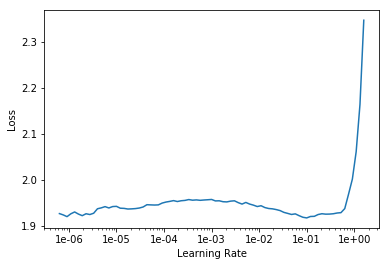

In [98]:
learn.recorder.plot()

In [99]:
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.794280,1.801478,0.205887,00:17
1,1.780448,1.765595,0.224222,00:16
2,1.769909,1.763034,0.222204,00:17
3,1.761427,1.751036,0.241884,00:16
4,1.745613,1.749429,0.239024,00:16


In [100]:
learn.save('first')

In [101]:
learn.load('first');

In [102]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.745450,1.742284,0.252481,00:19


In [103]:
learn.save('second')

In [104]:
learn.load('second');

In [105]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.700668,1.688683,0.283263,00:29


In [106]:
learn.save('third')

In [107]:
learn.load('third');

In [108]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.612810,1.676680,0.302607,00:40
1,1.585041,1.672504,0.310681,00:40


In [109]:
# Test a  line from a spearate dataset
pred_class,pred_idx,outputs=learn.predict("(telling Chandler the seating arrangement) Okay so this is where the\nband is. (Points.) And this is where the bar is. (Points) And all these pins have\npeoples names on them. (She has pins to show the seating at each of the tables.) And\nRach, here you are. (Points to Rachels place.)")
print(pred_class)

MONICA
